In [1]:
import multiprocessing
print(multiprocessing.cpu_count())

from psutil import virtual_memory

mem = virtual_memory()
print(mem.total >> 30)

2
3


- Most computers nowaway come with mutiple cores
- Taking advantage of mutltiple cores can help improving execution speed and resource utilization

#### Concurrent Programming == Parallel Programming?

- **Concurrent Programming**: Facilitate the progression of multiple tasks at the same time. 
- **Parallel Programming**: Facilitate the execution of multiple tasks at the same time. 

#### Notebook Source:

https://github.com/bfortuner/ml-study/blob/master/multitasking_python.ipynb

In [2]:
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor
import time
import numpy as np
import matplotlib.pyplot as plt
import glob
import random
import string
%matplotlib inline

https://docs.python.org/3/library/concurrent.futures.html

In [3]:
MULTITHREADING_TITLE="Multithreading"
MULTIPROCESSING_TITLE="Multiprocessing"

- When a **program** is run, the operating system original spawns a single **process** to execute all instructions inside this program. 
- A **thread** is a path of execution inside a **process**. 
- There can be **multiple threads** inside a process. 
- There can be **multiple processes** as requested by a program. 

- **Process** versus **Thread**
  - **Thread** is also called *lightweight process*
  - All **threads** within a process share that process' memory space.
  - Each **process** within the same program has its own memory space. 

#### Why Thread?

- Faster context switch.
- Effective utilization of multiple processor system.
- More convenient resource sharing. 
- Easier and faster communication. 

#### Why Process?

- Threads share memory space, creating potential risk of inconsistency.
  - Reading from stale memory location. 
  - Writing into supposedly static memory location. 
- For Python, you don't have to deal with GIL (Global Intepreter Lock)

**Use the right tool for the job**

In [4]:
def visualize_runtimes(results, title):
    start,stop = np.array(results).T
    plt.barh(range(len(start)),stop-start,left=start)
    plt.grid(axis='x')
    plt.ylabel("Tasks")
    plt.xlabel("Seconds")
    plt.title(title)
    return stop[-1]-start[0]

In [5]:
#https://docs.python.org/3/library/concurrent.futures.html#concurrent.futures.Executor.map

def multithreading(func, args, workers):
    begin_time = time.time()
    with ThreadPoolExecutor(max_workers=workers) as executor:
        res = executor.map(func, args, [begin_time for i in range(len(args))])
    return list(res)
        
def multiprocessing(func, args, workers):
    begin_time = time.time()
    with ProcessPoolExecutor(max_workers=workers) as executor: 
        res = executor.map(func, args, [begin_time for i in range(len(args))])
    return list(res)


# API Calls

In [6]:
from urllib.request import urlopen

def download(url, base):
    start = time.time() - base
    try:
        resp = urlopen(url)
    except Exception as e:
        print ('ERROR: %s' % e)
    stop = time.time() - base
    return start,stop

In [7]:
N = 16
URL = 'http://scholar.princeton.edu/sites/default/files/oversize_pdf_test_0.pdf'
urls = [URL for i in range(N)]

#### Serial

In [8]:
%timeit -n 1 [download(url, 1) for url in urls]

6.19 s ± 294 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### Multithreading

6.481207609176636

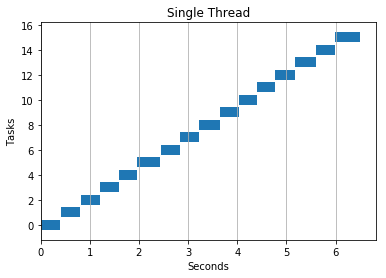

In [9]:
visualize_runtimes(multithreading(download, urls, 1), "Single Thread")

3.408954620361328

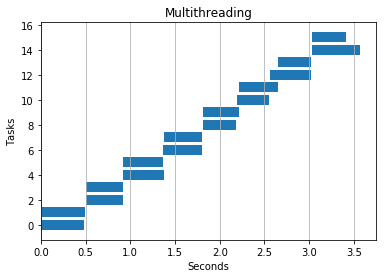

In [10]:
visualize_runtimes(multithreading(download, urls, 2),MULTITHREADING_TITLE)

2.187267780303955

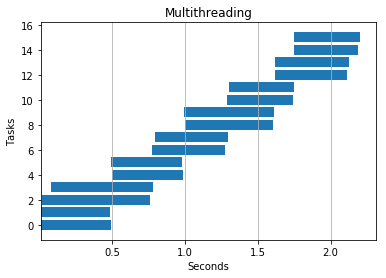

In [11]:
visualize_runtimes(multithreading(download, urls, 4),MULTITHREADING_TITLE)

#### Multiprocessing

6.778166055679321

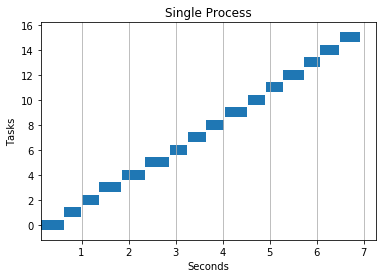

In [12]:
visualize_runtimes(multiprocessing(download, urls, 1), "Single Process")

3.4162726402282715

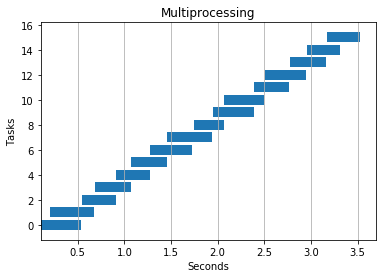

In [13]:
visualize_runtimes(multiprocessing(download, urls, 2), MULTIPROCESSING_TITLE)

2.0278122425079346

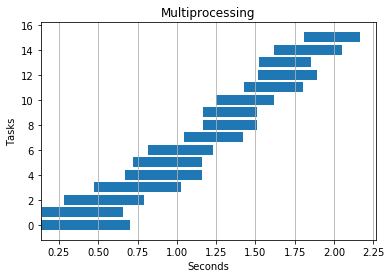

In [14]:
visualize_runtimes(multiprocessing(download, urls, 4), MULTIPROCESSING_TITLE)

# IO Heavy

In [15]:
def io_heavy(text,base):
    start = time.time() - base
    f = open('output.txt', 'wt', encoding='utf-8')
    f.write(text)
    f.close()
    stop = time.time() - base
    return start,stop

In [16]:
N=12
TEXT = ''.join(random.choice(string.ascii_lowercase) for i in range(10**4*5))

#### Serial

In [17]:
%timeit -n 1 [io_heavy(TEXT,1) for i in range(N)]

5.22 s ± 314 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### Multithreading

Should see good benefit from this

7.242332696914673

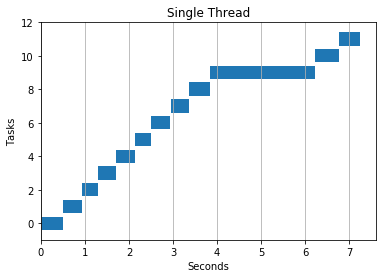

In [18]:
visualize_runtimes(multithreading(io_heavy, [TEXT for i in range(N)], 1),"Single Thread")

5.052239179611206

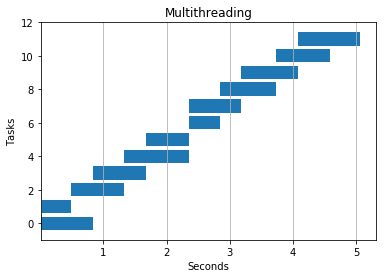

In [19]:
visualize_runtimes(multithreading(io_heavy, [TEXT for i in range(N)], 2),MULTITHREADING_TITLE)

4.854746580123901

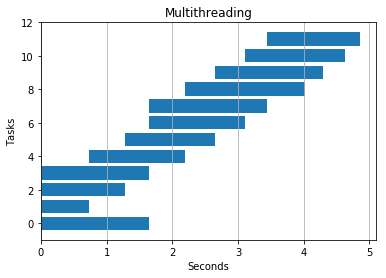

In [20]:
visualize_runtimes(multithreading(io_heavy, [TEXT for i in range(N)], 4),MULTITHREADING_TITLE)

#### Multiprocessing

Should see good benefit from this

5.168126583099365

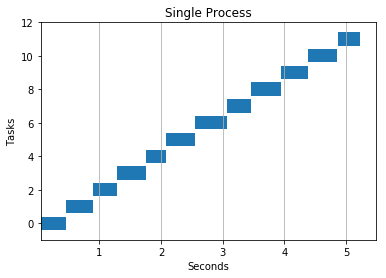

In [21]:
visualize_runtimes(multiprocessing(io_heavy, [TEXT for i in range(N)], 1),"Single Process")

4.372396469116211

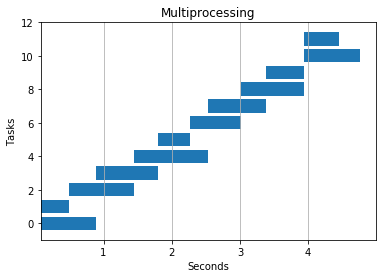

In [22]:
visualize_runtimes(multiprocessing(io_heavy, [TEXT for i in range(N)], 2),MULTIPROCESSING_TITLE)

4.891981601715088

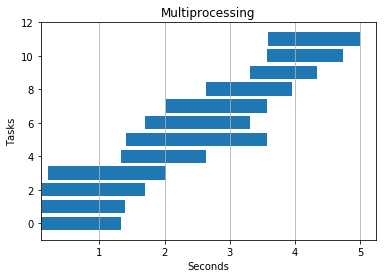

In [23]:
visualize_runtimes(multiprocessing(io_heavy, [TEXT for i in range(N)], 4),MULTIPROCESSING_TITLE)

### CPU Intensive

In [24]:
def cpu_heavy(n,base):
    start = time.time() - base
    count = 0
    for i in range(n):
        count += i
    stop = time.time() - base
    return start,stop

In [25]:
N = 10**7
ITERS = 10

#### Serial

In [26]:
%timeit -n 1 [cpu_heavy(N, time.time()) for i in range(ITERS)]

39.4 s ± 1.22 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### Multithreading

No benefit on CPU-intensive tasks

36.952287912368774

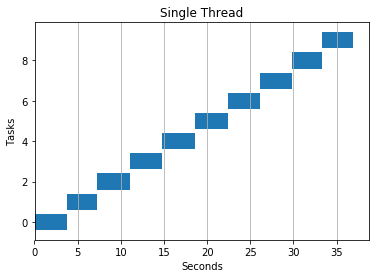

In [27]:
visualize_runtimes(multithreading(cpu_heavy, [N for i in range(ITERS)], 1),"Single Thread")

32.54035544395447

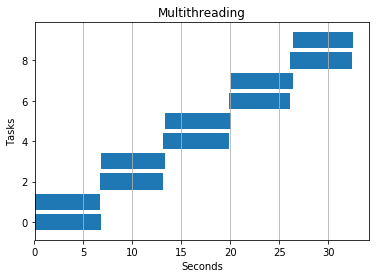

In [28]:
visualize_runtimes(multithreading(cpu_heavy, [N for i in range(ITERS)], 2),MULTITHREADING_TITLE)

33.53562521934509

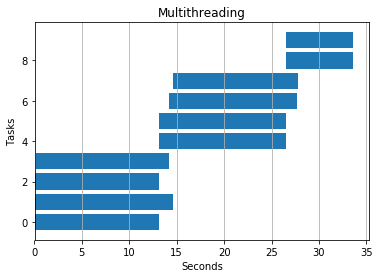

In [29]:
visualize_runtimes(multithreading(cpu_heavy, [N for i in range(ITERS)], 4),MULTITHREADING_TITLE)

#### Multiprocessing

Shows benefits on CPU-intensive tasks

37.89540123939514

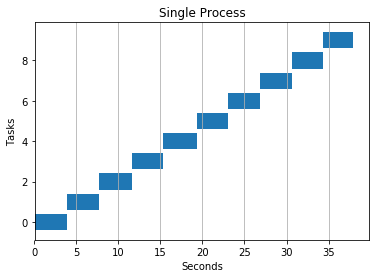

In [30]:
visualize_runtimes(multiprocessing(cpu_heavy, [N for i in range(ITERS)], 1),"Single Process")

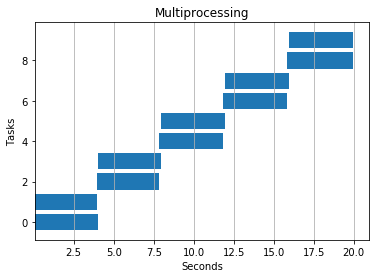

In [31]:
visualize_runtimes(multiprocessing(cpu_heavy, [N for i in range(ITERS)], 2),MULTIPROCESSING_TITLE)

20.72812509536743

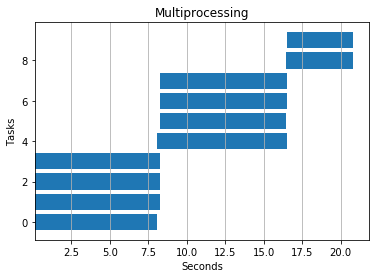

In [32]:
visualize_runtimes(multiprocessing(cpu_heavy, [N for i in range(ITERS)], 4),MULTIPROCESSING_TITLE)